In [19]:
import numpy as np
import pandas as pd
import seaborn as sns
from datasets import load_dataset, Dataset, load_from_disk
import matplotlib.pyplot as plt 
from openai import AzureOpenAI
import json

/home/yilong/miniconda3/envs/vllm/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [20]:
REGION = "eastus"
MODEL = "gpt-4o-mini-2024-07-18"
#REGION = "canadaeast"
#MODEL = "gpt-35-turbo-0125"
API_KEY = "bc49699a65744c068ceb605bbc992034"

API_BASE = "https://api.tonggpt.mybigai.ac.cn/proxy"
ENDPOINT = f"{API_BASE}/{REGION}"


client = AzureOpenAI(
    api_key=API_KEY,
    api_version="2024-02-01",
    azure_endpoint=ENDPOINT,
)

In [21]:
test_hitom = load_dataset('parquet', data_files='data/test/test_hitom.parquet')['train']

In [22]:
test_hitom

Dataset({
    features: ['deception', 'story_length', 'question_order', 'sample_id', 'story', 'question', 'choices', 'answer', 'question_old', 'answer_old', 'prompt'],
    num_rows: 600
})

In [31]:
SYSTEM_PROMPT = """Read the following story and answer the question. Think step-by-step. Provide the answer first,and then explain it. Answer in the following JSON format:
{
"answer": "answer text",
"explain": "step by step thinking"
}
"""

XML_COT_FORMAT = """Story: {}\n Question:{}"""

In [32]:
test_hitom['story'][0]

'Charlotte, Isabella, Elizabeth and Owen entered the living_room. lettuce is in the green_drawer. moved the lettuce to the green_bathtub. dislikes the tangerine. exited the living_room. moved the lettuce to the blue_pantry. likes the green_envelope. exited the living_room. made no movements and stayed in the living_room for 1 minute. exited the living_room. dislikes the green_pepper. made no movements and stayed in the living_room for 1 minute. exited the living_room. moved the lettuce to the green_drawer. exited the living_room. Charlotte, Isabella, Elizabeth and Owen entered the waiting_room.'

In [33]:
test_hitom['question'][0]

'Where is the lettuce really?'

In [34]:
i = 8
prompt_task =XML_COT_FORMAT.format(test_hitom['story'][i], test_hitom['question'][i])

response = client.chat.completions.create(
    model=MODEL,
    messages=[{"role": "system", "content":SYSTEM_PROMPT},
        {"role": "user", "content": prompt_task}
    ],
    temperature = 0.2,
    top_p = 0.1
)

print(response.choices[0].message.content)

{
"answer": "green_envelope",
"explain": "1. The story states that the banana is initially in the green_envelope. 2. The characters made no movements for 1 minute after entering the bedroom, which means the banana remained in the green_envelope during that time. 3. They then moved the banana to the blue_bottle, but it is not clear if this was a permanent move. 4. After that, they again moved the banana back to the green_envelope. 5. Since the last action mentioned is moving the banana back to the green_envelope, it indicates that the banana is currently in the green_envelope."
}


In [35]:
eval(response.choices[0].message.content)

{'answer': 'green_envelope',
 'explain': '1. The story states that the banana is initially in the green_envelope. 2. The characters made no movements for 1 minute after entering the bedroom, which means the banana remained in the green_envelope during that time. 3. They then moved the banana to the blue_bottle, but it is not clear if this was a permanent move. 4. After that, they again moved the banana back to the green_envelope. 5. Since the last action mentioned is moving the banana back to the green_envelope, it indicates that the banana is currently in the green_envelope.'}

In [38]:
json.loads(response.choices[0].message.content)['answer']

'green_envelope'

In [11]:
test_hitom['answer'][i]

'green_drawer'

In [39]:
def get_progress(progress, total):
    '''获取进度条'''
    progress_ratio = progress / total
    progress_len = 20
    progress_num = int(progress_ratio * 20)
    pro_text = '[{:-<20s}] {:.2f}% {} / {}'.format(
        '=' * progress_num, progress_ratio * 100, progress, total)
    return pro_text

In [40]:
results = {'outputs':[], 'answer':[], 'i':[]}
for i in range(len(test_hitom)):
    print(get_progress(i, len(test_hitom)), end = '\r')
    for j in range(3):
        try:
            prompt_task =XML_COT_FORMAT.format(test_hitom['story'][i], test_hitom['question'][i])

            response = client.chat.completions.create(
                model=MODEL,
                messages=[{"role": "system", "content":SYSTEM_PROMPT},
                    {"role": "user", "content": prompt_task}
                ],
                temperature = 0.2,
                top_p = 0.1
            ) 
            results['outputs'].append(json.loads(response.choices[0].message.content))
            results['answer'].append(test_hitom['answer'][i])
            results['i'].append(i)
            break
        except:
            print(i, ': ', response.choices[0].message.content)

211 :  {-------------] 35.17% 211 / 600
"answer": "green_bathtub",
"explain": "1. The story mentions that the melon was initially in the green_bathtub. 2. It was then moved to the blue_pantry, then to the green_bucket, and finally back to the green_bathtub. 3. Since the last recorded location of the melon is the green_bathtub, that is where it is really located."
}
211 :  {
"answer": "green_bathtub",
"explain": "1. The story mentions that the melon was initially in the green_bathtub. 2. It was then moved to the blue_pantry, then to the green_bucket, and finally back to the green_bathtub. 3. Since the last recorded location of the melon is the green_bathtub, that is where it is really located."
}
217 :  {-------------] 36.17% 217 / 600
"answer": "green_pantry",
"explain": "1. The eggplant starts in the green_pantry. 2. It is moved to the blue_drawer, then to the green_box. 3. Emily and Jack later find the eggplant in the green_box. 4. They move it to the green_bottle, and then to the gr

In [48]:
ik  = []
for i in range(600):
    if i not in results['i']:
        ik.append(i)

In [49]:
results2 = {'outputs':[], 'answer':[], 'i':[]}
for i in ik:
    print(i, end = '\r')
    for j in range(3):
        try:
            prompt_task =XML_COT_FORMAT.format(test_hitom['story'][i], test_hitom['question'][i])

            response = client.chat.completions.create(
                model=MODEL,
                messages=[{"role": "system", "content":SYSTEM_PROMPT},
                    {"role": "user", "content": prompt_task}
                ],
                temperature = 0.2,
                top_p = 0.1
            ) 
            results2['outputs'].append(json.loads(response.choices[0].message.content))
            results2['answer'].append(test_hitom['answer'][i])
            results2['i'].append(i)
            break
        except:
            print(i, ': ', response.choices[0].message.content)

254 :  {
"answer": "blue_treasure_chest",
"explain": "1. The spinach starts in the green_drawer. 2. It is moved to the green_pantry, then to the red_container, and back to the green_drawer. 3. After that, it is moved to the green_cupboard, then to the blue_treasure_chest. 4. The last known location of the spinach is the blue_treasure_chest, as there are no further movements mentioned after that."
}
582 :  {
"answer": "in the green_bathtub",
"explain": "To determine where Charlotte thinks Emily thinks Mila thinks the persimmon is, we need to analyze the information provided in the story. Mila, Benjamin, Emma, and Charlotte entered the waiting room and publicly claimed that the persimmon is in the green_bucket. However, Mila privately told Emily that the persimmon is in the green_bathtub. Since Charlotte is aware of the public claim but not the private conversation, she would assume that Emily believes Mila thinks the persimmon is in the green_bucket. However, since Emily knows the truth

In [51]:
results2['i']


[219, 254, 284, 285, 341, 508, 509, 543, 569, 582]

In [56]:
df = pd.concat([pd.DataFrame(results), pd.DataFrame(results2)], ignore_index=True)
df.sort_values(by='i', inplace=True, ignore_index=True)
df.head(2)

,outputs,answer,i
0,"{'answer': 'green_drawer', 'explain': '1. The ...",green_drawer,0
1,"{'answer': 'blue_container', 'explain': '1. Th...",blue_container,1


In [111]:
import re

def extract_xml_answer(text: str) -> str:
    answer_pattern = r'<answer>(.*?)</answer>'
    matches = list(re.finditer(answer_pattern, text, re.DOTALL))
    if not matches:
        return None
        
    final_answer = matches[-1].group(1).strip()
    return final_answer



def normalize_answer(answer: str) -> str:
    """Normalizes the answer text for better comparison.
    Args:
        answer: Raw answer text
    Returns:
        Normalized answer text
    """
    if answer is None:
        return None
    # Convert to lowercase
    normalized = answer.lower()
    # Remove extra whitespace
    normalized = re.sub(r'\s+', ' ', normalized).strip()
    # Remove punctuation that doesn't affect meaning
    normalized = re.sub(r'[.,;:!?]', '', normalized)
    return normalized


def reward_func(response, answer):
    response_ = response
    #response_ = extract_xml_answer(response)
    if response_:
        norm_response = normalize_answer(response_)
        norm_answer = normalize_answer(answer)
        ans_pattern = r"\b(?:in|at|on|inside|)?\s*(?:the\s*)?(?:\w+'s\s*)?" + re.escape(norm_answer) + r"\s*\b$"
        match = re.match(ans_pattern, norm_response, re.DOTALL | re.MULTILINE)
        if match:
            return 1
        else:
            return 0
    return 0

In [112]:
correct = [reward_func(each['answer'], ans) for each, ans in zip(df.outputs, df.answer)]

In [113]:
df.outputs[0]['answer']

'green_drawer'

In [114]:
for each in ['deception','question_order','question']:
    df[each]=test_hitom[each]

In [115]:
df.head(2)

,outputs,answer,i,reward,deception,question_order,question
0,"{'answer': 'green_drawer', 'explain': '1. The ...",green_drawer,0,1,False,0,Where is the lettuce really?
1,"{'answer': 'blue_container', 'explain': '1. Th...",blue_container,1,1,False,0,Where is the tomato really?


<Axes: xlabel='question_order', ylabel='reward'>

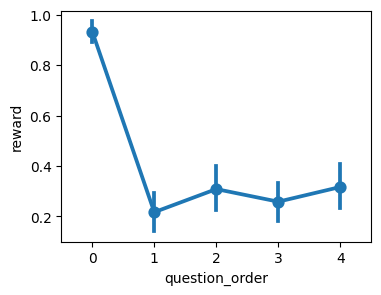

In [116]:
_, ax = plt.subplots(1,1,figsize=(4, 3))
sns.pointplot(x='question_order', y='reward', data=df)

<Axes: xlabel='question_order', ylabel='reward'>

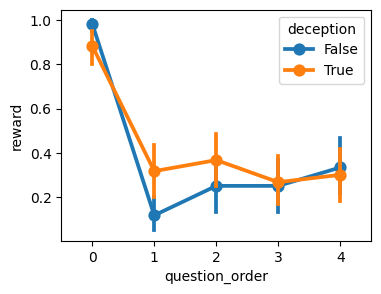

In [78]:
_, ax = plt.subplots(1,1,figsize=(4, 3))
sns.pointplot(x='question_order', y='reward', hue='deception', data=df)

In [79]:
df.reward.mean()

0.4066666666666667

In [77]:
df.to_csv('data/results/base/hittom_gpt4omini.csv', index=False)

0

In [122]:
reward_func("in A's box ", 'box')

1

In [110]:
reward_func(" in t's box ", 'box')

1

In [123]:
np.mean([1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])

0.3375

In [126]:
np.array([1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]).reshape(-1, 8)

array([[1., 1., 1., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1., 0., 0., 0.],
       [0., 0., 1., 1., 1., 1., 1., 0.],
       [0., 0., 1., 0., 1., 1., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1., 0., 1., 0.],
       [1., 0., 0., 0., 1., 0., 1., 1.],
       [1., 1., 0., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 0., 1., 0., 0., 1.],
       [0., 0., 0., 0., 1., 1., 1., 0.],
       [0., 1., 1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 1., 0.],
       [1., 1., 0., 0., 0., 1., 1., 0.],
       [1., 1., 0., 0., 0., 1., 0., 1.],
       [0., 0., 0., 0., 1., 0., 0., 0.],
       [1., 0., 

In [125]:
np.array([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]).reshape(-1, 8)

array([[1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 

In [127]:
np.array([1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]).reshape(-1, 8)

array([[1., 1., 1., 1., 0., 1., 1., 1.],
       [1., 1., 1., 1., 0., 1., 1., 1.],
       [1., 1., 0., 1., 1., 1., 0., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 0., 0., 0., 0., 1., 0.],
       [1., 1., 1., 0., 1., 1., 0., 1.],
       [1., 1., 1., 1., 0., 0., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 1., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 0., 1., 0., 1., 0., 0.],
       [0., 0., 1., 1., 1., 0., 0., 0.],
       [1., 0., 0., 0., 1., 1., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 0., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 1., 0., 0., 0., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 